In [ ]:
!pip install swalign


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for swalign: filename=swalign-0.3.7-py3-none-any.whl size=8518 sha256=70120b5446d44d8dd0674595c9c79e5a2cd9d7c8fe520c370041f3b78cca8961
  Stored in directory: /root/.cache/pip/wheels/6e/e0/e1/4af3c301cc5fe3d5d74370801450e9a41ecdb5c3e3a00f932e
Successfully built swalign


In [ ]:
import swalign

dna_string = "ATCCACAGC"
reference_string = "ATGCAGCGC"
match_score = 2
mismatch_score = -1
matrix = swalign.NucleotideScoringMatrix(match_score, mismatch_score)
lalignment_object = swalign.LocalAlignment(matrix)
alignment_object = lalignment_object.align(dna_string, reference_string)
alignment_object.dump()

Query:  1 ATGCAGC-GC 9
          ||.|| | ||
Ref  :  1 ATCCA-CAGC 9

Score: 11
Matches: 7 (70.0%)
Mismatches: 3
CIGAR: 5M1I1M1D2M


In [ ]:

sars = "GTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGT--AGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAA-GAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTG"
mers = "GTGTTAGTTAATGCTGCTAACACACATCTTAAGCATGGCGGTGGTATCGCTGGTGCTATTAATGCGGCTTCAAAAGGGGCTGTCCAAAAAGAGTCAGATGAGTATATTCTGGCTAAAGGGCCGTTACAAGTAGGAGATTCAGTTCTCTTGCAA--GGCCATTCTCTAGCTAAGAATATCCTGCATGTCGTAGGCCCAGATGCCCGCGCTAAACAGGATGTTTCTCTCCTTAGTAAGTGC-TATAAGGCTATGAATGCATATCCTCTTGTAGTCACTCCTCTTGTTTCAGCAGGCATATTTGGTG"
match_score = 2
mismatch_score = -1
matrix = swalign.NucleotideScoringMatrix(match_score, mismatch_score)
lalignment_object = swalign.LocalAlignment(matrix)
alignment_object = lalignment_object.align(sars, mers)
alignment_object.dump()

Query:   1 GT-GTTAGTTAATGCTGCTAA--CACACATCTTAAGCATGGCGGTGGTATCGCTGGTG-CTATTAATGCGGCTTC-AA-AAGGGGC-TGTCCAAAAAGAGTCAGATGAGTATAT-TCTGGCTAAAGGGCC-GTTACAAGTAGGAGATTCAGTTCTCTTGCAA--GG-C-CATTCTCTAGCTAAGA-A-TATCCTGCATGTCGTAGGCCCAGATGCCCGCGCTAA-ACAGG--ATG--TTTC-TCTCCTTAGTA--AGTGC-TAT-AAGGCTATGAAT--GCA--TA-TCCT-CTTGTAGTCACTCCTCT-TGTTTCAGCAGGCATATTTGGTG 301
           || ||| ||||||||.||.||  ...||  |||||.|||||.||.|||.|.||.||.| || |.|||..||||.| || || .|.| ||  |||...||.||.|||||.||.|| .|| .||||.||.|| .||| ||||.||.|.|..||||.|.||..||..|| | ||.||| | ||||| | | |.| ||.|||||.||.||||||.|||      .||| |.|||  |.|  .||| .||.||||  |  |||||.||| || ..|.|.|||  |||  .| |.|| ||||    ||| |.| | | |.|||||.||.||.|||||||
Ref  :   1 GTGGTT-GTTAATGCAGCCAATGTTTAC--CTTAAACATGGAGGAGGTGTTGCAGGAGCCT-TAAATAAGGCTACTAACAA-TGCCATG--CAAGTTGAATCTGATGATTACATAGCT-ACTAATGGACCACTTA-AAGTGGGTGGT--AGTTGTGTTTTAAGCGGACACAATCT-T-GCTAA-ACACTGT-CTTCATGTTGTCGGCCCAAATG------TTAACAAAGGTGAAGACATTCAACTTCTTA--A-GAGTGCTTATGAA-AATTTTAATCAGCACGAAGTTCTACTT

In [ ]:
import numpy as np

def smith_waterman(a: str, b: str, alignment_score: float = 1, gap_cost: float = 1) -> float:
  """
  Compute the Smith-Waterman alignment score for two strings.
  See https://en.wikipedia.org/wiki/Smith%E2%80%93Waterman_algorithm#Algorithm
  This implementation has a fixed gap cost (i.e. extending a gap is considered
  free). In the terminology of the Wikipedia description, W_k = {c, c, c, ...}.
  This implementation also has a fixed alignment score, awarded if the relevant
  characters are equal.
  Kinda slow, especially for large (50+ char) inputs.
  """
  # H holds the alignment score at each point, computed incrementally
  H = np.zeros((len(a) + 1, len(b) + 1))
  for i in range(1, len(a) + 1):
    for j in range(1, len(b) + 1):
      # The score for substituting the letter a[i-1] for b[j-1]. Generally low
      # for mismatch, high for match.
      match = H[i-1,j-1] + (alignment_score if a[i-1] == b[j-1] else 0)
      # The scores for for introducing extra letters in one of the strings (or
      # by symmetry, deleting them from the other).
      delete = H[1:i,j].max() - gap_cost if i > 1 else 0
      insert = H[i,1:j].max() - gap_cost if j > 1 else 0
      H[i,j] = max(match, delete, insert, 0)
  
  return H.max()

In [ ]:
smith_waterman(sars, mers)

180.0

The highest score is the best local alignment.
For our purposes, we don't actually care _what_ the alignment was, just how
aligned the two strings were.

In [ ]:
from enum import IntEnum
import numpy as np

# Assigning the constants for the scores
class Score(IntEnum):
    MATCH = 1
    MISMATCH = -1
    GAP = -1

# Assigning the constant values for the traceback
class Trace(IntEnum):
    STOP = 0
    LEFT = 1 
    UP = 2
    DIAGONAL = 3
    
    
def smith_watermanss(seq1, seq2):
    # Generating the empty matrices for storing scores and tracing
    row = len(seq1) + 1
    col = len(seq2) + 1
    matrix = np.zeros(shape=(row, col), dtype=np.int)  
    tracing_matrix = np.zeros(shape=(row, col), dtype=np.int)  
    
    # Initialising the variables to find the highest scoring cell
    max_score = -1
    max_index = (-1, -1)
    
    # Calculating the scores for all cells in the matrix
    for i in range(1, row):
        for j in range(1, col):
            # Calculating the diagonal score (match score)
            match_value = Score.MATCH if seq1[i - 1] == seq2[j - 1] else Score.MISMATCH
            diagonal_score = matrix[i - 1, j - 1] + match_value
            
            # Calculating the vertical gap score
            vertical_score = matrix[i - 1, j] + Score.GAP
            
            # Calculating the horizontal gap score
            horizontal_score = matrix[i, j - 1] + Score.GAP
            
            # Taking the highest score 
            matrix[i, j] = max(0, diagonal_score, vertical_score, horizontal_score)
            
            # Tracking where the cell's value is coming from    
            if matrix[i, j] == 0: 
                tracing_matrix[i, j] = Trace.STOP
                
            elif matrix[i, j] == horizontal_score: 
                tracing_matrix[i, j] = Trace.LEFT
                
            elif matrix[i, j] == vertical_score: 
                tracing_matrix[i, j] = Trace.UP
                
            elif matrix[i, j] == diagonal_score: 
                tracing_matrix[i, j] = Trace.DIAGONAL 
                
            # Tracking the cell with the maximum score
            if matrix[i, j] >= max_score:
                max_index = (i,j)
                max_score = matrix[i, j]
    
    # Initialising the variables for tracing
    aligned_seq1 = ""
    aligned_seq2 = ""   
    current_aligned_seq1 = ""   
    current_aligned_seq2 = ""  
    (max_i, max_j) = max_index
    
    # Tracing and computing the pathway with the local alignment
    while tracing_matrix[max_i, max_j] != Trace.STOP:
        if tracing_matrix[max_i, max_j] == Trace.DIAGONAL:
            current_aligned_seq1 = seq1[max_i - 1]
            current_aligned_seq2 = seq2[max_j - 1]
            max_i = max_i - 1
            max_j = max_j - 1
            
        elif tracing_matrix[max_i, max_j] == Trace.UP:
            current_aligned_seq1 = seq1[max_i - 1]
            current_aligned_seq2 = '-'
            max_i = max_i - 1    
            
        elif tracing_matrix[max_i, max_j] == Trace.LEFT:
            current_aligned_seq1 = '-'
            current_aligned_seq2 = seq2[max_j - 1]
            max_j = max_j - 1
            
        aligned_seq1 = aligned_seq1 + current_aligned_seq1
        aligned_seq2 = aligned_seq2 + current_aligned_seq2
    
    # Reversing the order of the sequences
    aligned_seq1 = aligned_seq1[::-1]
    aligned_seq2 = aligned_seq2[::-1]
    
    return aligned_seq1, aligned_seq2


In [ ]:
smith_watermanss(sars, mers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

('GTGGTT-GTTAATGCAGCCAATGTTTAC--CTTAAACATGGAGGAGGTGTTGCAGGAGCC-TTAAATAAGGCTACTAACAATGC-CATG-C-AAGTTGAATCTGATGATTACATAGCTA-CTAATGGACCACTTA-AAGTGGGTGGT--AGTTGTGTTTTAAGCGGACACAATCT-T-GCTAA-ACACTGTCTT-CATGTTGTCGGCCCAAATGT------TAACAAAGGTGAAGACATTCAACTTCTTAA-G-A-GTGCTTATGAAAATTTT-AATCAGCACGAAGTTCTACTTG----CAC-CAT-TA-TTATCAGCTGGTATTTTTGGTG',
 'GTG-TTAGTTAATGCTGCTAACAC--ACATCTTAAGCATGGCGGTGGTATCGCTGGTGCTATTAA-TGCGGCTTC-AA-AAGGGGC-TGTCCAAAAAGAGTCAGATGAGTATATT-CTGGCTAAAGGGCCG-TTACAAGTAGGAGATTCAGTTCTCTTGCAA--GG-C-CATTCTCTAGCTAAGA-A-TATCCTGCATGTCGTAGGCCCAGATGCCCGCGCTAA-ACAGG--ATGT--TTCT-CTCCTTA--GTAAGTGC-TAT-AAGGCTATGAAT--GCAT-A--TCCT-CTTGTAGTCACTCCTCTTGTT-TCAGCAGGCATATTTGGTG')

'GTGGTT-GTTAATGCAGCCAATGTTTAC--CTTAAACATGGAGGAGGTGTTGCAGGAGCC-TTAAATAAGGCTACTAACAATGC-CATG-C-AAGTTGAATCTGATGATTACATAGCTA-CTAATGGACCACTTA-AAGTGGGTGGT--AGTTGTGTTTTAAGCGGACACAATCT-T-GCTAA-ACACTGTCTT-CATGTTGTCGGCCCAAATGT------TAACAAAGGTGAAGACATTCAACTTCTTAA-G-A-GTGCTTATGAAAATTTT-AATCAGCACGAAGTTCTACTTG----CAC-CAT-TA-TTATCAGCTGGTATTTTTGGTG',
 'GTG-TTAGTTAATGCTGCTAACAC--ACATCTTAAGCATGGCGGTGGTATCGCTGGTGCTATTAA-TGCGGCTTC-AA-AAGGGGC-TGTCCAAAAAGAGTCAGATGAGTATATT-CTGGCTAAAGGGCCG-TTACAAGTAGGAGATTCAGTTCTCTTGCAA--GG-C-CATTCTCTAGCTAAGA-A-TATCCTGCATGTCGTAGGCCCAGATGCCCGCGCTAA-ACAGG--ATGT--TTCT-CTCCTTA--GTAAGTGC-TAT-AAGGCTATGAAT--GCAT-A--TCCT-CTTGTAGTCACTCCTCTTGTT-TCAGCAGGCATATTTGGTG'

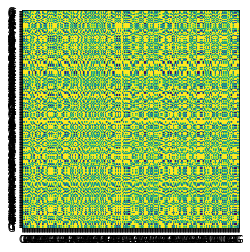

In [ ]:
import numpy
from past.builtins import xrange

import matplotlib.pyplot as plt
dotplot=plt.imshow(numpy.array(makeMatrix(mers,sars,1)))
xt=plt.xticks(numpy.arange(len(list(mers))),list(mers))
yt=plt.yticks(numpy.arange(len(list(sars))),list(sars))
plt.show()

In [ ]:
class Solution(object):
    def findRepeatedDnaSequences(self, s):
        m = {}
        for i in range(len(s)):
            m[s[i : i + 5]] = 1 + m.get(s[i : i + 5], 0)
        return [key for key, value in m.items() if value > 1]

In [ ]:
Solution().findRepeatedDnaSequences(mers)

['TTAGT',
 'TTAAT',
 'TAATG',
 'AATGC',
 'TGCTA',
 'GCTAA',
 'ACACA',
 'GCATG',
 'TGGTG',
 'GCTAT',
 'CAAAA',
 'AAAAG',
 'AAAGG',
 'AAGGG',
 'AGTCA',
 'CAGAT',
 'AGATG',
 'ATATT',
 'ATTCT',
 'GGCTA',
 'CTAAA',
 'GTAGG',
 'TTCAG',
 'TTCTC',
 'TCTCT',
 'CTCTT',
 'TCTTG',
 'ATATC',
 'TATCC',
 'ATCCT',
 'TGCAT',
 'TGTTT',
 'GTTTC',
 'CTCCT',
 'GCATA',
 'CATAT',
 'TCCTC',
 'CCTCT',
 'CTTGT']

In [ ]:
Solution().findRepeatedDnaSequences(sars)

['GTGGT',
 'GTTGT',
 'TGTTA',
 'GTTAA',
 'TTAAT',
 'TAATG',
 'AATGC',
 'ATGCA',
 'TGCAG',
 'CAATG',
 'AATGT',
 'ATGTT',
 'TGTTT',
 'CCTTA',
 'CTTAA',
 'TTAAA',
 'TAAAC',
 'AAACA',
 'ATGGA',
 'GGAGG',
 'AGGAG',
 'AGGTG',
 'GTGTT',
 'TGTTG',
 'TTGCA',
 'GCTAC',
 'CTACT',
 'TACTA',
 'ACTAA',
 'TAACA',
 'AACAA',
 'ACAAT',
 'AAGTT',
 'AGTTG',
 'AATCT',
 'TTTTA',
 'TTTAA',
 'CTTGC',
 'ATTTT',
 'ATCAG',
 'TCAGC',
 'ATTAT']

In [ ]:
sars = "GTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGT--AGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAA-GAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTG"

In [ ]:
len(sars)

304

In [ ]:
len("TTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTG")

40

In [ ]:
301-265

36

In [ ]:
len("GTGGTTGTTAATGCAGCCAATGTTTACCTTAAACATGGAGGAGGTGTTGCAGGAGCCTTAAATAAGGCTACTAACAATGCCATGCAAGTTGAATCTGATGATTACATAGCTACTAATGGACCACTTAAAGTGGGTGGT--AGTTGTGTTTTAAGCGGACACAATCTTGCTAAACACTGTCTTCATGTTGTCGGCCCAAATGTTAACAAAGGTGAAGACATTCAACTTCTTAA-GAGTGCTTATGAAAATTTTAATCAGCACGAAGTTCTACTTGCACCATTATTATCAGCTGGTATTTTTGGTG")

304